Problem Statement : A plastics manufacturing plant has recorded their monthly sales data from 1949 to 1953. Perform forecasting on the data and bring out insights from it and forecast the sale for the next year. 

Business Objective :

Maximize : The sales of the plastic in the future so that the overall revenue of the company be increased
    
Minimize : The wastage of the plastic and the production cost
    
Business Contraints : The availability of material and Budget of the ompany

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

In [19]:
plastic = pd.read_csv("PlasticSales.csv")


In [20]:
plastic.head()

,Month,Sales
0,Jan-49,742
1,Feb-49,697
2,Mar-49,776
3,Apr-49,898
4,May-49,1030


In [21]:
# Converting the normal index of Amtrak to time stamp 
plastic.index = pd.to_datetime(plastic.Month,format="%b-%y")

In [22]:
plastic.columns

Index(['Month', 'Sales'], dtype='object')

<Axes: >

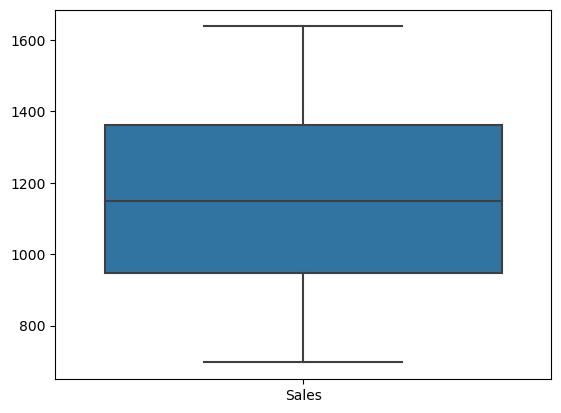

In [23]:
sns.boxplot(plastic)
# No outlier is present in the data

In [24]:
plastic.info()
# There is no null value present in the data 
# Month is string and Sales is numeric in nature

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2049-01-01 to 2053-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   60 non-null     object
 1   Sales   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1320\1973643371.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plastic.Sales)


<Axes: xlabel='Sales', ylabel='Density'>

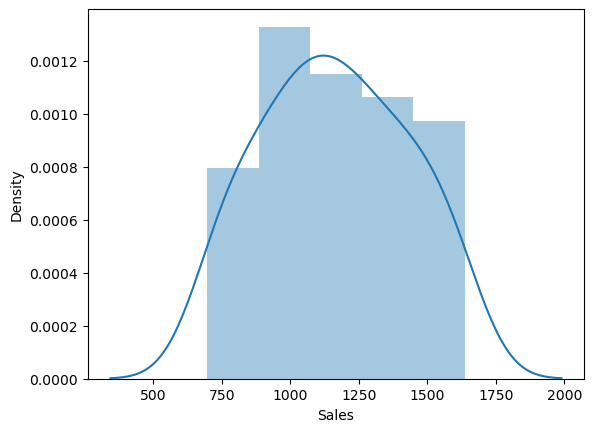

In [25]:
sns.distplot(plastic.Sales)
# The data is normally distributed

<Axes: xlabel='Month'>

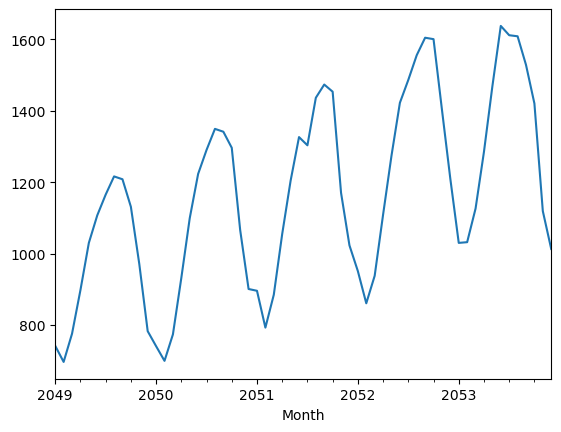

In [26]:
# Time series plot
plastic["Sales"].plot()
# As we observed the data is not stationary

In [27]:
# Creating a Date column to store the actual Date format for the given Month column
plastic["Date"] = pd.to_datetime(plastic.Month,format="%b-%y")

In [28]:
# Extracting Day, weekday name, month name, year from the Date column using 
# Date functions from pandas 

plastic["month"] = plastic.Date.dt.strftime("%b") # month extraction
plastic["year"] =plastic.Date.dt.strftime("%Y") # year extraction

<Axes: xlabel='month', ylabel='year'>

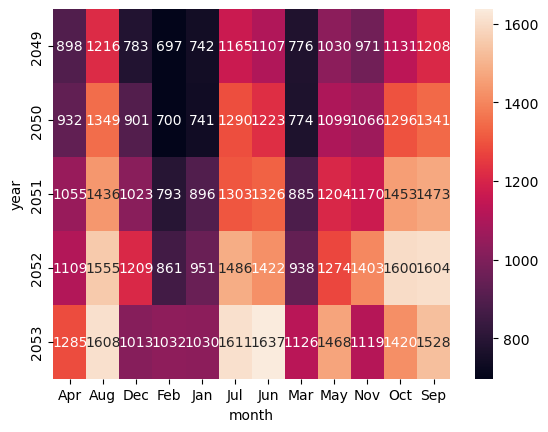

In [29]:
# Heat map visualization 
heatmap_y_month = pd.pivot_table(data=plastic,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")


<Axes: xlabel='year', ylabel='Sales'>

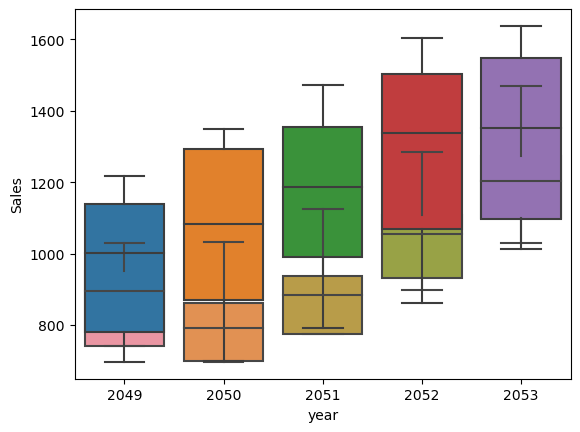

In [30]:
# Boxplot for ever
sns.boxplot(x="month",y="Sales",data=plastic)
sns.boxplot(x="year",y="Sales",data=plastic)

<Axes: xlabel='year', ylabel='Sales'>

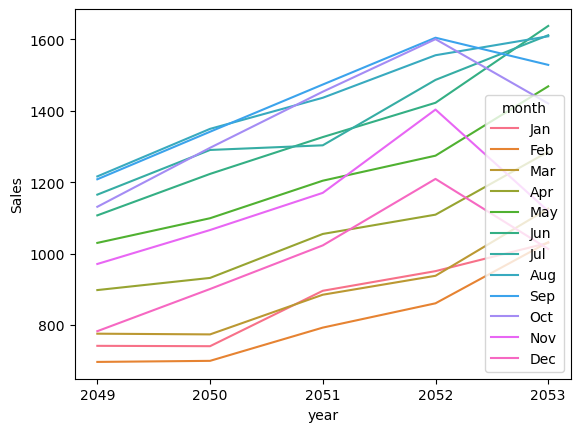

In [31]:
# Line plot for Ridership based on year  and for each month
sns.lineplot(x="year",y="Sales",hue="month",data=plastic)
# As we see in data there is some variation according to the month
# for jan,jun,july ,aug,sept the plastic sales suddenly increases

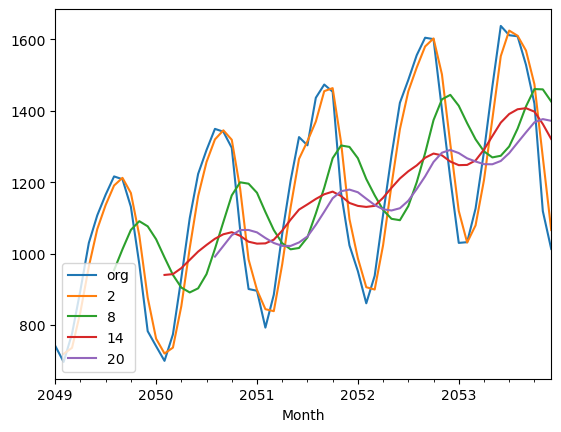

In [32]:
# moving average for the time series to understand better about the trend character in Plastic
plastic.Sales.plot(label="org")
for i in range(2,24,6):
    plastic["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

# As we see in the following output the sales constatntly increases 
# Means this is not stationary 

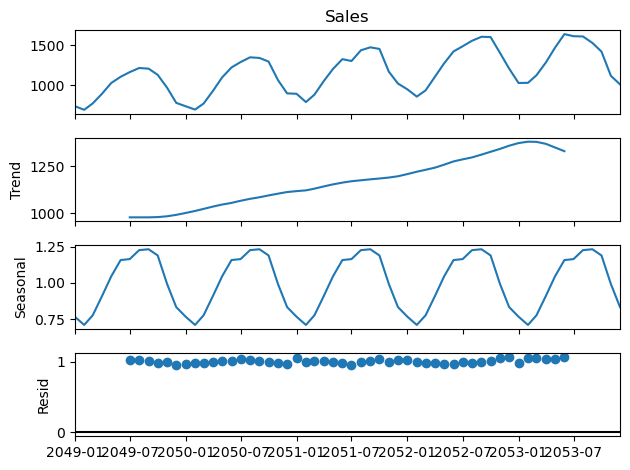

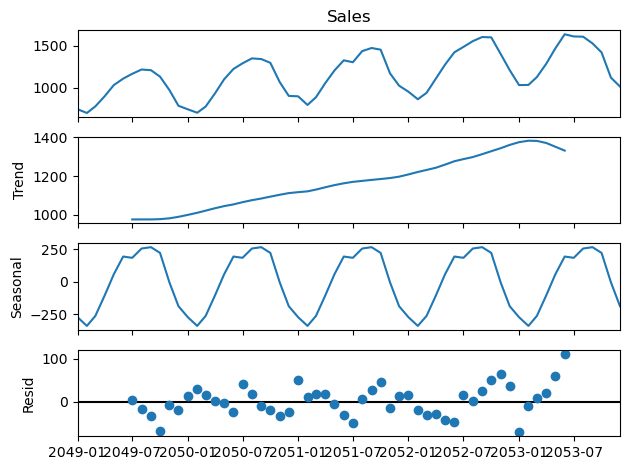

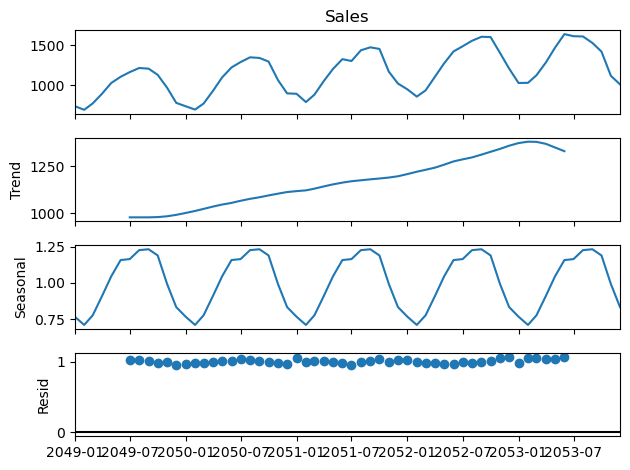

In [34]:
# Time series decomposition plot 
decompose_ts_add = seasonal_decompose(plastic.Sales,model="additive")
decompose_ts_add.plot()
decompose_ts_mul = seasonal_decompose(plastic.Sales,model="multiplicative")
decompose_ts_mul.plot()
    

In [ ]:
# As we see there is stillthe nature is non-stationary for additive
# But when we comes to multiplicative the data is become constant and statinary

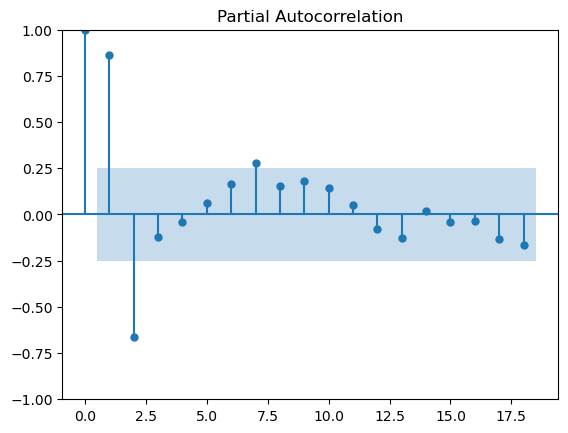

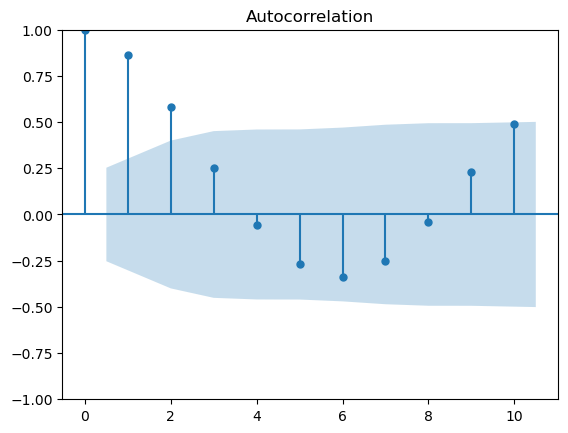

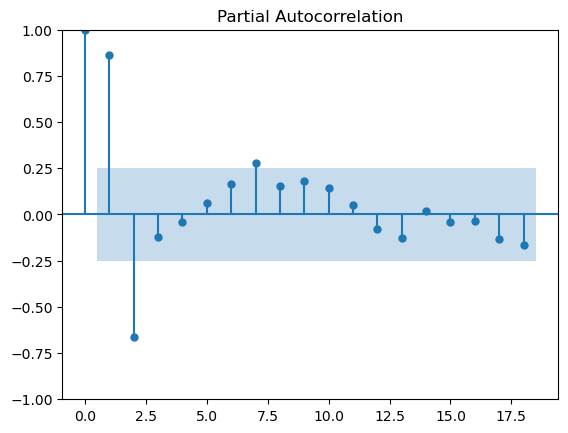

In [36]:
# ACF plots and PACF plots on Original data sets 
tsa_plots.plot_acf(plastic.Sales,lags=10)
tsa_plots.plot_pacf(plastic.Sales)

In [37]:
# splitting the data into Train and Test data and considering the last 12 months data as 
# Test data and left over data as train data 

Train = plastic.head(48)
Test = plastic.tail(12)

In [38]:
# Creating a function to calculate the MAPE value for test data 
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)


In [39]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales) # 17.04

C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


17.041821212339293

In [40]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) #101.985

C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


102.9016274095817

In [41]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales) # 14.422


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1320\2750920292.py:2: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=12,damped=True).fit()
C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


11.502418584633515

In [42]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales) #14.994


C:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


14.989698252830294